In [1]:
import sys
import torch
from matplotlib import pyplot as plt
import seaborn as sns
import time
import os
from IPython.display import clear_output
import numpy as np

dir_path = os.getcwd()
dir_path = os.path.dirname(dir_path)

sys.path.append(dir_path)

from a3c.ActorCritic import ActorCritic
from dark_room import DarkRoom
from gpt.GPT import GPT
from gpt.Tokenizer import Tokenizer
from gpt.config import CFG

In [3]:
# fix random seed
seed = 42


def reset_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


reset_seed(seed)

In [4]:
env = DarkRoom()
input_dim = env.observation_space.shape[0]
action_space = env.action_space.n


def render_env(env, title, speepTime=0):
    # clear previous image
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.title(title)
    # plt.axis("off")
    plt.show()
    time.sleep(speepTime)

In [5]:
epiodes = 50
max_steps_per_episode = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### ActorCritic

In [6]:
a3c = ActorCritic(input_dim, action_space).to(device)
# load the model
a3c.load_state_dict(torch.load("../models/a3c_model.pth", weights_only=False))

<All keys matched successfully>

In [7]:
def a3c_step(state):
    policy, _ = a3c(
        torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    )
    action = torch.softmax(policy, dim=-1).argmax().item()
    return action


state = env.reset()
done = False

In [8]:
ac3_info = dict()
reset_seed(seed)
for e in range(epiodes):
    state = env.reset(use_random_agent_pos=True)
    done = False
    ac3_info[e] = dict(
        {
            "steps": 0,
        }
    )
    while not done:
        action = a3c_step(state)
        ac3_info[e]["steps"] += 1
        state, _, done = env.step(action)
        # uncomment to see the agent in action
        # render_env(env, f"Episode: {e}")
        if done:
            break
    print(f"Episode {e} done")

Episode 0 done
Episode 1 done
Episode 2 done
Episode 3 done
Episode 4 done
Episode 5 done
Episode 6 done
Episode 7 done
Episode 8 done
Episode 9 done
Episode 10 done
Episode 11 done
Episode 12 done
Episode 13 done
Episode 14 done
Episode 15 done
Episode 16 done
Episode 17 done
Episode 18 done
Episode 19 done
Episode 20 done
Episode 21 done
Episode 22 done
Episode 23 done
Episode 24 done
Episode 25 done
Episode 26 done
Episode 27 done
Episode 28 done
Episode 29 done
Episode 30 done
Episode 31 done
Episode 32 done
Episode 33 done
Episode 34 done
Episode 35 done
Episode 36 done
Episode 37 done
Episode 38 done
Episode 39 done
Episode 40 done
Episode 41 done
Episode 42 done
Episode 43 done
Episode 44 done
Episode 45 done
Episode 46 done
Episode 47 done
Episode 48 done
Episode 49 done


#### GPT

In [9]:
# gpt = ADTransformer(CFG)
gpt = GPT()
gpt.load_state_dict(torch.load("../models/gpt_model.pth", weights_only=False))
gpt.eval()
gpt.cpu()
gpt.to(device)

tokenizer = Tokenizer()
state = env.reset()
history = [[state[0], state[1], 0, 0]]

In [10]:
def gpt_step(action_history, max_len=CFG.context_size // 4 - 1):
    if len(action_history) > max_len:
        action_history = action_history[-max_len:]
    tokenized = torch.tensor(
        [tokenizer(action_history)], dtype=torch.long, device=device
    )
    logits, _ = gpt(tokenized)
    action = torch.argmax(logits, dim=1).item()
    return action

In [12]:
context = []
returns = []
window_sizes = [
    CFG.context_size // 4 - 1,
    CFG.context_size // 8,
    CFG.context_size // 16,
    CFG.context_size // 32,
    1,
]

env = DarkRoom()
gpt_info = dict()


for window_size in window_sizes:
    reset_seed(seed)
    gpt_info[window_size] = dict()
    context = []
    for episode in range(epiodes):
        state = env.reset(use_random_agent_pos=True)
        if len(context) == 0:
            context = [[state[0], state[1], 0, -1]]
        done = False
        gpt_info[window_size][episode] = dict(
            {
                "steps": 0,
            }
        )
        total_return = 0
        for _ in range(max_steps_per_episode):
            action = gpt_step(context, window_size)
            state, reward, done = env.step(action)
            context.append([state[0], state[1], action, reward])
            total_return += reward
            gpt_info[window_size][episode]["steps"] += 1
            # uncomment to see the agent in action
            # render_env(env, episode)

            if done:
                break

    returns.append(total_return)

#### Compare GPT and ActorCritic

Compare amount of steps that GPT and ActorCritic need to reach the goal.

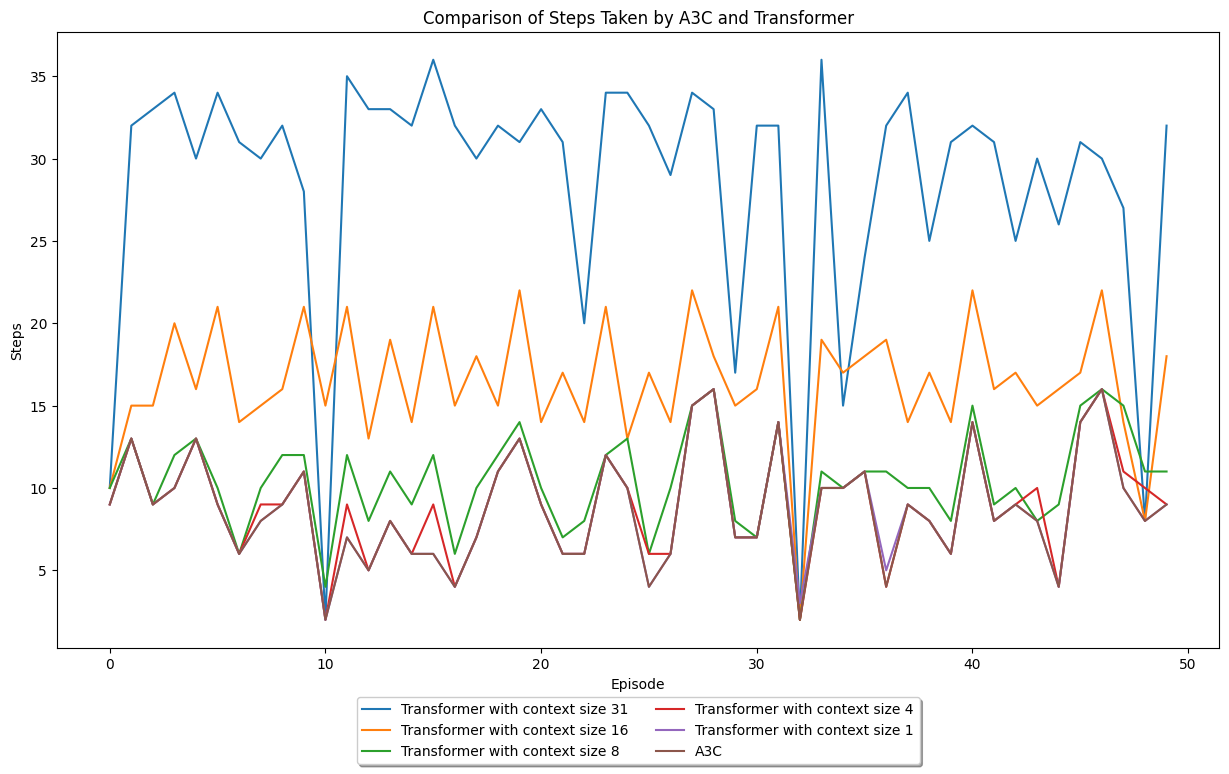

In [13]:
plt.figure(figsize=(15, 8))

for k in gpt_info.keys():
    sns.lineplot(
        [gpt_info[k][e]["steps"] for e in gpt_info[k].keys()],
        label=f"Transformer with context size {k}",
    )
sns.lineplot([ac3_info[k]["steps"] for k in ac3_info.keys()], label="A3C")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Comparison of Steps Taken by A3C and Transformer")
plt.legend(
    loc="lower center", bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2
)
plt.show()